In [1]:
!pip install unidecode
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 3.4 MB/s 
     |████████████████████████████████| 930 kB 28.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tqdm
import pickle
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode

# Topic Modelling
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from pprint import pprint

In [4]:
def convert_tolist(string):
    text = list(string.split(" "))
    return text

Data Import

In [35]:
with open('/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/data_topic.pkl', "rb") as f:
    data_topic = pickle.load(f)

# Topic Modelling


1.1 Quali sono i topic più comuni relativi al Covid-19?\
1.2 Quali topic hanno una proporzioni più alta di fake e real news?

In [62]:
data_topic_mod = data_topic.copy() # create a copy

In [63]:
data_topic_mod['Text_for_topic'] = data_topic_mod['Text_cleaned'].apply(lambda x: convert_tolist(x)) # questo perchè ho bisogno di una lista per fare i dictionary del topic modelling

In [9]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-05-24 15:05:52--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-05-24 15:05:53--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  6.64MB/s    in 2.3s    

2022-05-24 15:05:56 (6.64 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [10]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'

---
Compute the optimal number of topics according to the value of alpha and two different cardinality for top n parameter.
- 5, 10
- 5, 10, 15
This means that the coherence scores per topic is first calculated by using a top_n cardinality of 5, 10 and 15 and then averaged to give the final coherence score per topic.
---



In [11]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    # Put your own PATH_TO_MALLET here
    PATH_TO_MALLET = '/content/mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET,
                                                 corpus = corpus,
                                                 num_topics = num_topics,
                                                 id2word = dictionary,
                                                 alpha = 0.2,
                                                 iterations = 100)
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model,
                                        texts = texts,
                                        dictionary = dictionary,
                                        coherence = 'c_v', # COHERENCE VALUE
                                        topn = topn) # Integer corresponding to the number of top words to be extracted from each topic.
        
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
all_scores = []
for n in range(5, 15, 5): #5,10 parole e poi farlo con 5,10,15 parole
    model_list, coherence_values = compute_coherence_values(texts = data_topic_mod['Text_for_topic'], start=1, step=1, limit= 16, topn=n)
    all_scores.append(coherence_values)
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)
print(avg_scores)

In [ ]:
max_value = max(avg_scores)
max_idx = list(avg_scores).index(max_value)

print('Maximum Coherence Value:', max_value, "Number of Topics: ", max_idx + 1)

In [ ]:
results = [
     [('{5,10}'), '0.01', 0.43401513896789334, '14'],
     [('{5,10,15}'), '0.01', 0.4148125265059595 , '15'],
     [('{5,10}'), '0.05',  0.519956929895342 , '6'],
     [('{5,10,15}'), '0.05',  0.46584251940074667 , '6'],
     [('{5,10}'), '0.1', 0.5070662275141095, '5'],
     [('{5,10,15}'), '0.1', 0.47852114848123795 , '10'],
     [('{5,10}'), '0.2',  0.5712864685248302 , '4'],
     [('{5,10,15}'), '0.2',  0.48846126981587396 , '9']
     ]

In [ ]:
results_cv = pd.DataFrame(results, columns= ['TopN', 'Alpha', 'Coherence Value', 'Optimal No of Topic'])
results_cv

,TopN,Alpha,Coherence Value,Optimal No of Topic
0,"{5,10}",0.01,0.434015,14
1,"{5,10,15}",0.01,0.414813,15
2,"{5,10}",0.05,0.519957,6
3,"{5,10,15}",0.05,0.465843,6
4,"{5,10}",0.1,0.507066,5
5,"{5,10,15}",0.1,0.478521,10
6,"{5,10}",0.2,0.571286,4
7,"{5,10,15}",0.2,0.488461,9


In [12]:
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/content/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS,
                    alpha = 0.2)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

In [64]:
topics, lda_model, dictionary = topic_modelling_results(data_topic_mod['Text_for_topic'], 4, n_iterations = 500)

In [ ]:
# Save LDA model
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/lda_model.pkl", "wb") as f:
    pickle.dump(lda_model, f)

## 1.1 Quali sono i topic più comuni relativi al Covid-19?

In [65]:
topics

,Topic,Words
0,0,vaccine vaccination pfizer health information moderna county vaccinated booster appointment
1,1,conspiracy gate bill pandemic theory network technology event world spread
2,2,china outbreak disease wuhan case chinese people city spread death
3,3,vaccine vaccination health service case pandemic worker travel italy mask


In [67]:
pprint(lda_model.print_topics())

[(0,
  '0.143*"vaccine" + 0.025*"vaccination" + 0.014*"pfizer" + 0.012*"health" + '
  '0.009*"information" + 0.008*"moderna" + 0.008*"county" + 0.007*"vaccinated" '
  '+ 0.007*"booster" + 0.007*"appointment"'),
 (1,
  '0.029*"conspiracy" + 0.029*"gate" + 0.026*"bill" + 0.026*"pandemic" + '
  '0.025*"theory" + 0.014*"network" + 0.012*"technology" + 0.011*"event" + '
  '0.010*"world" + 0.010*"spread"'),
 (2,
  '0.072*"china" + 0.025*"outbreak" + 0.021*"disease" + 0.021*"wuhan" + '
  '0.017*"case" + 0.016*"chinese" + 0.012*"people" + 0.011*"city" + '
  '0.010*"spread" + 0.009*"death"'),
 (3,
  '0.020*"vaccine" + 0.011*"vaccination" + 0.010*"health" + 0.007*"service" + '
  '0.007*"case" + 0.007*"pandemic" + 0.006*"worker" + 0.006*"travel" + '
  '0.005*"italy" + 0.005*"mask"')]


In [68]:
df_lda = pd.DataFrame()
for topic_n, list_terms_w in lda_model.show_topics(formatted=False):
    df_tmp = pd.DataFrame(list_terms_w, columns=["Topic " + str(topic_n) + " word", "Topic " + str(topic_n) + " weight"])
    df_lda = pd.concat([df_lda, df_tmp], axis=1)

In [69]:
df_lda

,Topic 0 word,Topic 0 weight,Topic 1 word,Topic 1 weight,Topic 2 word,Topic 2 weight,Topic 3 word,Topic 3 weight
0,vaccine,0.143084,conspiracy,0.029388,china,0.072056,vaccine,0.020032
1,vaccination,0.025437,gate,0.029187,outbreak,0.024699,vaccination,0.010807
2,pfizer,0.013627,bill,0.026167,disease,0.021229,health,0.010279
3,health,0.012037,pandemic,0.025564,wuhan,0.020821,service,0.007380
4,information,0.009312,theory,0.024960,case,0.016738,case,0.006589
5,moderna,0.007949,network,0.014291,chinese,0.016126,pandemic,0.006589
6,county,0.007722,technology,0.012480,people,0.012452,worker,0.006062
7,vaccinated,0.007495,event,0.010668,city,0.011023,travel,0.006062
8,booster,0.007495,world,0.010266,spread,0.009798,italy,0.005271
9,appointment,0.007041,spread,0.010064,death,0.009390,mask,0.004744


In [70]:
df_lda['Topic 0 weight'] = df_lda['Topic 0 weight'].astype(float)
df_lda['Topic 1 weight'] = df_lda['Topic 1 weight'].astype(float)
df_lda['Topic 2 weight'] = df_lda['Topic 2 weight'].astype(float)
df_lda['Topic 3 weight'] = df_lda['Topic 3 weight'].astype(float)

In [71]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    y=df_lda['Topic 0 weight'],
    x=df_lda['Topic 0 word'],
    marker_color='#1E90FF',
    name='Topic 0'

))
fig.add_trace(go.Bar(
    y=df_lda['Topic 1 weight'],
    x=df_lda['Topic 1 word'],
    marker_color='#D2691E',
    name='Topic 1'

))
fig.add_trace(go.Bar(
    y=df_lda['Topic 2 weight'],
    x=df_lda['Topic 2 word'],
    marker_color='#228B22',
    name='Topic 2'

))
fig.add_trace(go.Bar(
    y=df_lda['Topic 3 weight'],
    x=df_lda['Topic 3 word'],
    marker_color='#CD5C5C',
    name='Topic 3'
    
))



fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Word distribution per Topics',
                   yaxis_title='Weights', xaxis_title='Terms')
fig.show()

In [72]:
transformed_docs = lda_model.load_document_topics()

In [73]:
# We calculate the probability for each record to belong to the four topics found.

for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

Output streaming troncato alle ultime 5000 righe.
Topic distributions for document 162
(0, 0.00352112676056338)
(1, 0.00352112676056338)
(2, 0.9894366197183098)
(3, 0.00352112676056338)
Topic distributions for document 163
(0, 0.0027472527472527475)
(1, 0.9368131868131869)
(2, 0.0027472527472527475)
(3, 0.057692307692307696)
Topic distributions for document 164
(0, 0.00308641975308642)
(1, 0.3117283950617284)
(2, 0.6820987654320988)
(3, 0.00308641975308642)
Topic distributions for document 165
(0, 0.002906976744186047)
(1, 0.1191860465116279)
(2, 0.23546511627906977)
(3, 0.6424418604651163)
Topic distributions for document 166
(0, 0.9524793388429751)
(1, 0.0020661157024793385)
(2, 0.0020661157024793385)
(3, 0.04338842975206611)
Topic distributions for document 167
(0, 0.6856060606060607)
(1, 0.0037878787878787884)
(2, 0.0037878787878787884)
(3, 0.3068181818181818)
Topic distributions for document 168
(0, 0.0024752475247524753)
(1, 0.0024752475247524753)
(2, 0.9925742574257427)
(3, 0.00

In [74]:
transformed_docs = lda_model.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs],
                                  columns=['topic_{}'.format(i) for i in range(4)])
data_topic_mod = pd.concat([data_topic_mod, topic_distributions], axis = 1)

In [75]:
data_topic_mod

,Title,Link,Label,Description,Original,Text_cleaned,Text_for_topic,topic_0,topic_1,topic_2,topic_3
0,"""Finally got 5G"": Ryan Reynolds shares photo of himself ...",https://dailyhive.com/vancouver/ryan-reynolds-covid-19-vaccination,1,"Vancouver-raised actor Ryan Reynolds shared a selfie on Twitter of his \nCOVID-19 vaccination this week, saying that he “finally got 5G.”.","""Finally got 5G"": Ryan Reynolds shares photo of himself ... Vancouver-raised actor Ryan Reynolds shared a selfie on Twitter of his \nCOVID-19 vaccination this week, saying that he “finally got 5G.”.",finally got ryan reynolds share photo vancouver raised actor ryan reynolds shared selfie twitter vaccination week saying finally got,"[finally, got, ryan, reynolds, share, photo, vancouver, raised, actor, ryan, reynolds, shared, selfie, twitter, vaccination, week, saying, finally, got]",0.003086,0.003086,0.188272,0.805556
1,Death toll from new coronavirus spikes in just a day | Live ...,https://www.livescience.com/china-coronavirus-death-toll-climbs.html,0,"death toll from a new coronavirus in China continues to climb. ... 17, 2020, in Wuhan, China, where an outbreak of a new coronavirus has sickened ... Future US, Inc. 11 West 42nd Street, 15th Floor, New York, NY 10036.","Death toll from new coronavirus spikes in just a day | Live ... death toll from a new coronavirus in China continues to climb. ... 17, 2020, in Wuhan, China, where an outbreak of a new coronavirus has sickened ... Future US, Inc. 11 West 42nd Street, 15th Floor, New York, NY 10036.",death toll new spike day live death toll new china continues climb wuhan china outbreak new sickened future inc west street floor new york,"[death, toll, new, spike, day, live, death, toll, new, china, continues, climb, wuhan, china, outbreak, new, sickened, future, inc, west, street, floor, new, york]",0.054688,0.002604,0.940104,0.002604
2,The 5G Covid-19 Quackery - Cenerva,https://cenerva.com/the-5g-covid-19-quackery/,0,I say this as I have heard on social media fora and elsewhere so-called Pastors and “experts” stand up and assert a proven biological virus a “hoax” and blame ...,The 5G Covid-19 Quackery - Cenerva I say this as I have heard on social media fora and elsewhere so-called Pastors and “experts” stand up and assert a proven biological virus a “hoax” and blame ...,quackery cenerva say heard social medium forum elsewhere called pastor expert stand assert proven biological hoax blame,"[quackery, cenerva, say, heard, social, medium, forum, elsewhere, called, pastor, expert, stand, assert, proven, biological, hoax, blame]",0.332237,0.661184,0.003289,0.003289
3,[The epidemiological characteristics of an outbreak of 2019 ...,https://pubmed.ncbi.nlm.nih.gov/32064853/,0,"Objective: An outbreak of 2019 novel coronavirus diseases (COVID-19) in Wuhan, China has spread quickly nationwide. Here, we report results of a descriptive ...","[The epidemiological characteristics of an outbreak of 2019 ... Objective: An outbreak of 2019 novel coronavirus diseases (COVID-19) in Wuhan, China has spread quickly nationwide. Here, we report results of a descriptive ...",epidemiological characteristic outbreak objective outbreak novel disease wuhan china spread quickly nationwide report result descriptive,"[epidemiological, characteristic, outbreak, objective, outbreak, novel, disease, wuhan, china, spread, quickly, nationwide, report, result, descriptive]",0.214789,0.003521,0.778169,0.003521
4,"5G, Religion, and Misconceptions in Communication during ...",https://journals.usm.ac.id/index.php/the-messenger/article/view/2282,0,"di BCE Ndinojuo Pastor Chris Oyakhilome, founder of Believers LoveWorld, added his voice to the 5G debate, claiming that Covid-19 lockdown was decoy to sequester the population ...","5G, Religion, and Misconceptions in Communication during ... di BCE Ndinojuo Pastor Chris Oyakhilome, founder of Believers LoveWorld, added his voice to the 5G debate, claiming that Covid-19 lockdown was decoy to sequester t

In [76]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/data_topic_mod.pkl", "wb") as f:
    pickle.dump(data_topic_mod, f)

In [77]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/data_topic_mod.pkl", "rb") as f:
    data_topic_mod = pickle.load(f)

In [78]:
data_topic_dist = data_topic_mod.copy() # duplicate for create a plot for data distribution

In [79]:
data_topic_dist.drop(['Title', 'Link', 'Text_cleaned', 'Text_for_topic'], axis=1, inplace = True) 

In [80]:
with open("/content/drive/MyDrive/Master_Thesis_D_Amico/pickle/data_topic_dist.pkl", "wb") as f:
    pickle.dump(data_topic_dist, f)

## 1.2 Quali topic hanno una proporzioni più alta di fake e real news?

In [81]:
data_fake.iloc[:, 3:7]

,topic_0,topic_1,topic_2,topic_3
0,0.188272,0.003086,0.126543,0.682099
9,0.002907,0.002907,0.991279,0.002907
13,0.003086,0.003086,0.990741,0.003086
16,0.158854,0.106771,0.731771,0.002604
23,0.002155,0.002155,0.993534,0.002155
...,...,...,...,...
1129,0.057692,0.002747,0.552198,0.387363
1134,0.003521,0.848592,0.144366,0.003521
1136,0.867284,0.003086,0.003086,0.126543
1159,0.188272,0.805556,0.003086,0.003086


In [82]:
data_fake = data_topic_dist[data_topic_dist.Label == 1]
data_fake['Max'] = data_fake.iloc[:, 3:7].idxmax(axis=1)
data_grouped_fake = data_fake.groupby("Max").count()
data_grouped_fake = data_grouped_fake.iloc[:, [1]]
data_grouped_fake

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Description
Max,
topic_0,15
topic_1,60
topic_2,42
topic_3,16


In [83]:
data_real = data_topic_dist[data_topic_dist.Label == 0]
data_real['Max'] = data_real.iloc[:, 3:7].idxmax(axis=1)
data_grouped_real = data_real.groupby("Max").count()
data_grouped_real = data_grouped_real.iloc[:, [1]]
data_grouped_real

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Description
Max,
topic_0,299
topic_1,270
topic_2,266
topic_3,194


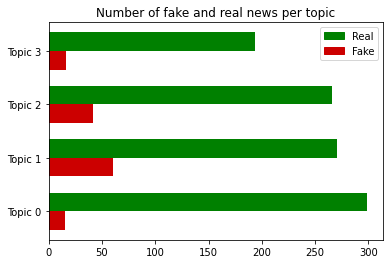

In [84]:
height1 = data_grouped_real['Description']
height2 = data_grouped_fake['Description']

bars = ('Topic 0', 'Topic 1', 'Topic 2', 'Topic 3')

x_pos = np.arange(len(bars))

# Create bars
plt.style.use('seaborn-deep')
plt.barh(x_pos, height1, alpha = 1, color = "#008000", height=0.35, align = 'edge')
plt.barh(x_pos, height2, alpha = 1, color = '#CC0000', height=-0.35, align = 'edge')

# Create names on the x-axis
plt.yticks(x_pos, bars, color='black')#,  rotation=90)
plt.xticks(color='black')

colors = {'Real':'#008000', 'Fake':'#CC0000'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.title("Number of fake and real news per topic")

# Show graphic
plt.savefig('/content/drive/MyDrive/Master_Thesis_D_Amico/images/fake_real_topic_dist.png')
plt.show()



---



---

